# Code to make Figure 11
- Decadal map composites over southern Ross Sea for temperature
- Notebook by Alice DuVivier (NCAR)
- June 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import dask
import cmocean
import geopandas as gpd

## Set some details for region

In [2]:
# set the location of the already extracted training data
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/'
path_out = path_in+'figure_code/final_figures/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

### Specify variables to plot

In [3]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
var_in_1 = 'TS'
var_in_2 = 'T'
var_in_3 = 'TGRAD'


In [4]:
# file name for training variable only here 
fin_1 = 'antarctic_data_for_som_composites_'+var_in_1
fin_2 = 'antarctic_data_for_som_composites_'+var_in_2
fin_3 = 'antarctic_data_for_som_composites_'+var_in_3

In [5]:
# load data
ds_1 = xr.open_mfdataset(data_path_in+fin_1+'.nc')
ds_2 = xr.open_mfdataset(data_path_in+fin_2+'.nc')
ds_3 = xr.open_mfdataset(data_path_in+fin_3+'.nc')

In [6]:
ds_1

<xarray.Dataset>
Dimensions:    (lat: 32, lon: 288, training_times: 7575)
Coordinates:
    time       (training_times) object dask.array<chunksize=(7575,), meta=np.ndarray>
    member_id  (training_times) object dask.array<chunksize=(7575,), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... -62.67 -61.73 -60.79
Dimensions without coordinates: training_times
Data variables:
    data       (lat, lon, training_times) float32 dask.array<chunksize=(32, 288, 7575), meta=np.ndarray>
Attributes:
    Author:    Alice DuVivier
    units:     K
    longname:  surface temperature

In [7]:
ds_1.units

'K'

### Load in ice data

In [8]:
# set what variables we can plot
var_composite_in = 'aice_d' 
print(var_composite_in)

aice_d


In [9]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [10]:
# load data
ds_ice = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

## Calculate the mean for all winter by decade

In [11]:
# calculate winter mean against which to do anomalies
mean_all_1 = ds_1.data.mean(dim='training_times')
mean_all_2 = ds_2.data.mean(dim='training_times')
mean_all_3 = ds_3.data.mean(dim='training_times')
mean_all_ice = ds_ice.data.mean(dim='training_times')

In [12]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [13]:
# make numpy array to fill and specify dimensions we want
decade_array_1 = np.zeros([len(decade_names),len(mean_all_1.lat),len(mean_all_1.lon)])
decade_array_2 = np.zeros([len(decade_names),len(mean_all_2.plev),len(mean_all_2.lat),len(mean_all_2.lon)])
decade_array_3 = np.zeros([len(decade_names),len(mean_all_3.plev),len(mean_all_3.lat),len(mean_all_3.lon)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array_1[d_count,:,:]   = ds_1.data.isel(training_times=ds_1.time.dt.year.isin([yy_all])).mean(dim='training_times')
    decade_array_2[d_count,:,:,:] = ds_2.data.isel(training_times=ds_2.time.dt.year.isin([yy_all])).mean(dim='training_times')
    decade_array_3[d_count,:,:,:] = ds_3.data.isel(training_times=ds_3.time.dt.year.isin([yy_all])).mean(dim='training_times')
    

decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [14]:
# make numpy array to fill and specify dimensions we want
decade_array_ice = np.zeros([len(decade_names),len(mean_all_ice.nj),len(mean_all_ice.ni)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array_ice[d_count,:,:] = ds_ice.data.isel(training_times=ds_ice.time.dt.year.isin([yy_all])).mean(dim='training_times')


decade: 1980s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 1990s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2000s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2010s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2020s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2030s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2040s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2050s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2060s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


decade: 2070s


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [15]:
print(decade_array_1.shape)
print(decade_array_2.shape)
print(decade_array_3.shape)
print(decade_array_ice.shape)

(10, 32, 288)
(10, 3, 32, 288)
(10, 3, 32, 288)
(10, 36, 320)


In [78]:
# convert the numpy array to a xarray for easier plotting
decade_means_1 = xr.DataArray(decade_array_1,dims=('decade','lat','lon'))
decade_means_2 = xr.DataArray(decade_array_2,dims=('decade','plev','lat','lon'))
decade_means_3 = xr.DataArray(decade_array_3,dims=('decade','plev','lat','lon'))
decade_means_ice = xr.DataArray(decade_array_ice,dims=('decade','nj','ni'))

In [79]:
# set coordinate arrays
decade_means_1['decade'] = decade_names
decade_means_1['lat'] = mean_all_1['lat'].values
decade_means_1['lon'] = mean_all_1['lon'].values

decade_means_2['decade'] = decade_names
decade_means_2['plev'] = mean_all_2['plev'].values
decade_means_2['lat'] = mean_all_2['lat'].values
decade_means_2['lon'] = mean_all_2['lon'].values

decade_means_3['decade'] = decade_names
decade_means_3['plev'] = mean_all_3['plev'].values
decade_means_3['lat'] = mean_all_3['lat'].values
decade_means_3['lon'] = mean_all_3['lon'].values

decade_means_ice['decade'] = decade_names
decade_means_ice['nj'] = mean_all_ice['nj'].values
decade_means_ice['ni'] = mean_all_ice['ni'].values

## Make plots

In [80]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

In [81]:
#set shape files info
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))

### Surface temperature

In [82]:
# Data details
title_in = 'Surface Temperature'
units = '(\xb0 C)'
levels_in = np.arange(-50,-15,2.5)
ticks_in = [-50,-45,-40,-35,-30,-25,-20]
cmap_in = cmocean.cm.thermal   

levels_diff = np.arange(-6,7,1)
ticks_diff = [-6,-4,-2,0,2,4,6]
cmap_diff = cmocean.cm.diff

# ice details
levels_ice_diff = np.arange(-25,30,5)
ticks_ice_diff = [-20,-15,-10,-5,0,5,10,15,20]

In [83]:
# bootstrap significance calculation 
# (only should be done for the far right panel; the diffs)

num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means_1.isel(decade=0).shape[0],
                      decade_means_1.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means_1.isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means_1.isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [84]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','lat','lon'))

# set coordinate arrays
boot_diff['lat'] = mean_all_1['lat'].values
boot_diff['lon'] = mean_all_1['lon'].values

In [85]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')


In [86]:
fout = path_out+'fig_11_TS'

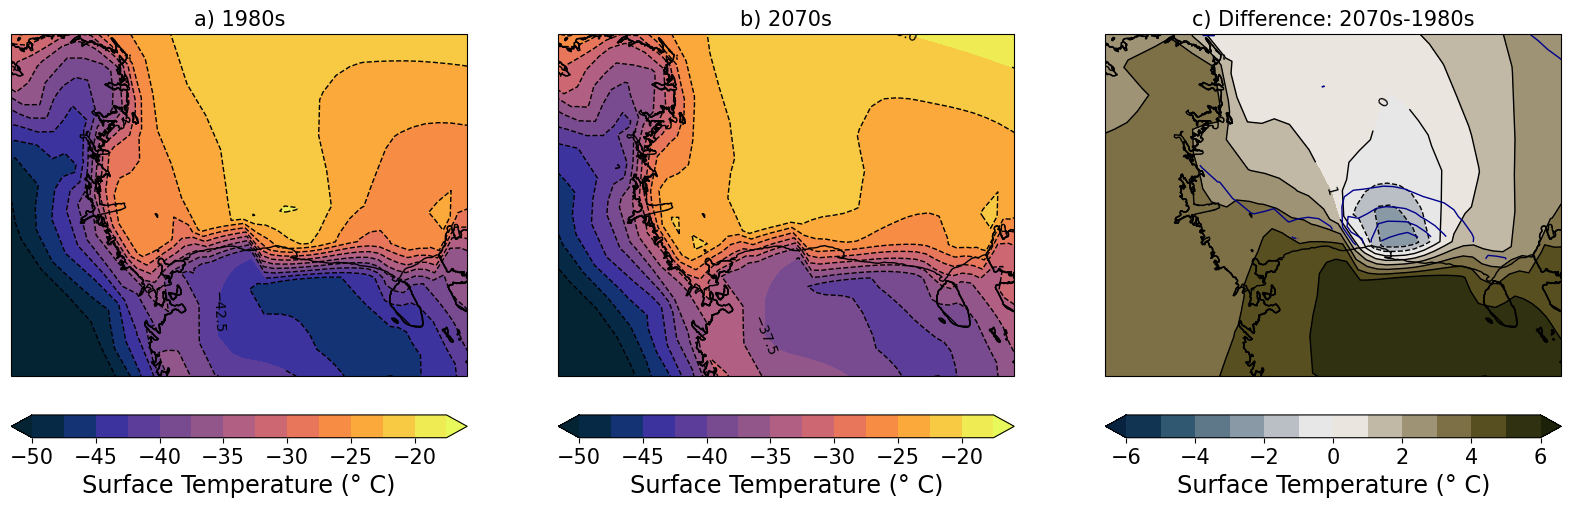

In [87]:
## 2070's difference figure
tag = '2070'

# select data
data_ctrl = decade_means_1.sel(decade='1980') - 273.15
data_in = decade_means_1.sel(decade=tag) - 273.15
data_diff = data_in - data_ctrl

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# select ice data
data_ice_ctrl = 100*decade_means_ice.sel(decade='1980')
data_ice_in = 100*decade_means_ice.sel(decade=tag)
data_ice_diff = data_ice_in - data_ice_ctrl

# create figure
fig = plt.figure(figsize=(20,10))

# get lats/lons for plotting
lons = ds_1.lon
lats = ds_1.lat
lons_ice = ds_ice.TLON
lats_ice = ds_ice.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)

### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('a) 1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('b) '+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_diff,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_diff)
# add significance overtop - stippling where it is NOT significant
#this3 = ax.pcolor(lons,lats,
#                  sig2,
#                  transform=ccrs.PlateCarree(),
#                  hatch='.',
#                  alpha= 0)
# add ice difference contours overtop
color = 'darkblue'
this1 = ax.contour(lons_ice,lats_ice,
                   data_ice_diff,
                   transform=ccrs.PlateCarree(),
                   colors = color,
                   levels=levels_ice_diff,extend='both',linewidths=1)
#plt.clabel(this1,colors=color,inline=1,fontsize=10,levels=ticks_ice_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('c) Difference: '+tag+'s-1980s',fontsize=15)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

### T at 850hPa

In [88]:
# Data details
title_in = '850hPa Temperature'
units = '(\xb0 C)'

levels_in = np.arange(-30,-14,2)
ticks_in = [-30,-28,-24,-20,-16]
cmap_in = cmocean.cm.thermal   

levels_diff = np.arange(-6,7,1)
ticks_diff = [-6,-4,-2,0,2,4,6]
cmap_diff = cmocean.cm.diff

# ice details
levels_ice_diff = np.arange(-25,30,5)
ticks_ice_diff = [-20,-15,-10,-5,0,5,10,15,20]

In [89]:
# bootstrap significance calculation 
# (only should be done for the far right panel; the diffs)
lev = 85000

num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means_1.isel(decade=0).shape[0],
                      decade_means_1.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means_2.sel(plev=lev).isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means_2.sel(plev=lev).isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [90]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','lat','lon'))

# set coordinate arrays
boot_diff['lat'] = mean_all_2['lat'].values
boot_diff['lon'] = mean_all_2['lon'].values

In [91]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [92]:
fout = path_out+'fig_11_T850'

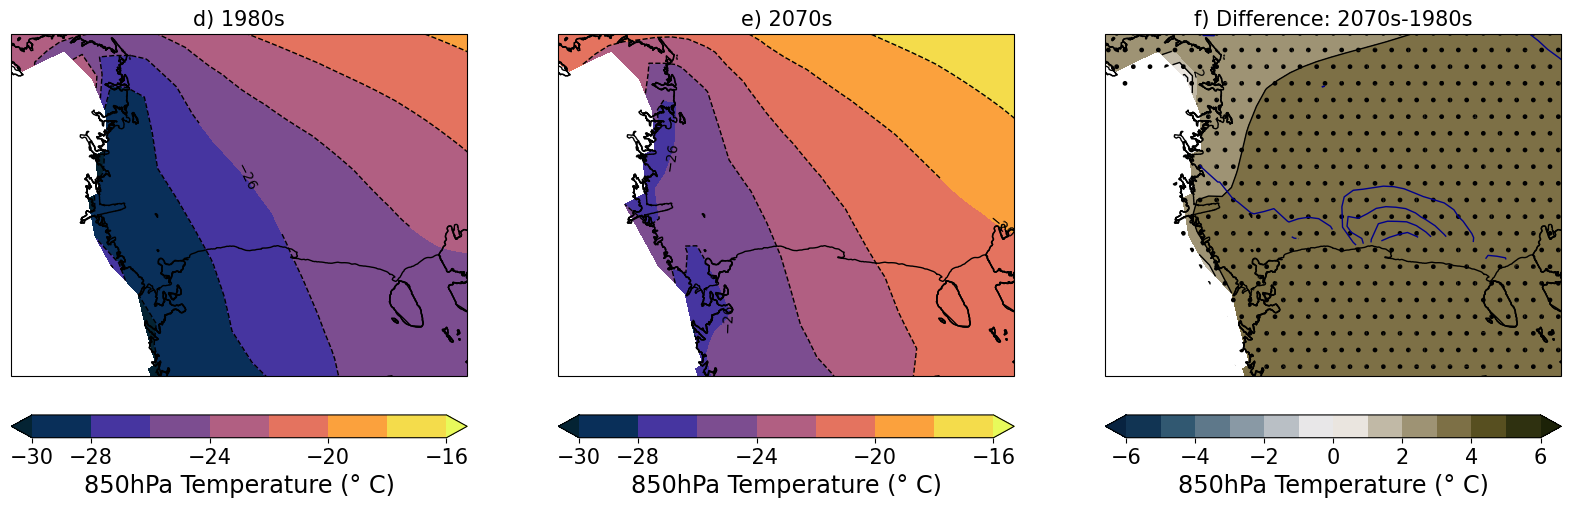

In [93]:
## 2070's difference figure
tag = '2070'
lev = 85000

# select data
data_ctrl = decade_means_2.sel(decade='1980',plev=lev) - 273.15
data_in = decade_means_2.sel(decade=tag,plev=lev) - 273.15
data_diff = data_in - data_ctrl

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# select ice data
data_ice_ctrl = 100*decade_means_ice.sel(decade='1980')
data_ice_in = 100*decade_means_ice.sel(decade=tag)
data_ice_diff = data_ice_in - data_ice_ctrl

# create figure
fig = plt.figure(figsize=(20,10))

# get lats/lons for plotting
lons = ds_1.lon
lats = ds_1.lat
lons_ice = ds_ice.TLON
lats_ice = ds_ice.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)

### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('d) 1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('e) '+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_diff,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_diff)
# add significance overtop - stippling where it is NOT significant
this3 = ax.pcolor(lons,lats,
                  sig2,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# add ice difference contours overtop
color = 'darkblue'
this1 = ax.contour(lons_ice,lats_ice,
                   data_ice_diff,
                   transform=ccrs.PlateCarree(),
                   colors = color,
                   levels=levels_ice_diff,extend='both',linewidths=1)
#plt.clabel(this1,colors=color,inline=1,fontsize=10,levels=ticks_ice_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('f) Difference: '+tag+'s-1980s',fontsize=15)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

### TGRAD at 850hPa - Sfc

In [94]:
# Data details
title_in = 'Temperature Gradient'
units = '(\xb0 C)'

levels_in = np.arange(-20,22,2)
ticks_in = [-20,-10,0,10,20]
cmap_in = cmocean.cm.balance   

levels_diff = np.arange(-6,7,1)
ticks_diff = [-6,-4,-2,0,2,4,6]
cmap_diff = cmocean.cm.diff

# ice details
levels_ice_diff = np.arange(-25,30,5)
ticks_ice_diff = [-20,-15,-10,-5,0,5,10,15,20]

In [95]:
# bootstrap significance calculation 
# (only should be done for the far right panel; the diffs)
lev = 85000

num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means_1.isel(decade=0).shape[0],
                      decade_means_1.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means_3.sel(plev=lev).isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means_3.sel(plev=lev).isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [96]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','lat','lon'))

# set coordinate arrays
boot_diff['lat'] = mean_all_2['lat'].values
boot_diff['lon'] = mean_all_2['lon'].values

In [97]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [98]:
fout = path_out+'fig_11_TGRAD'

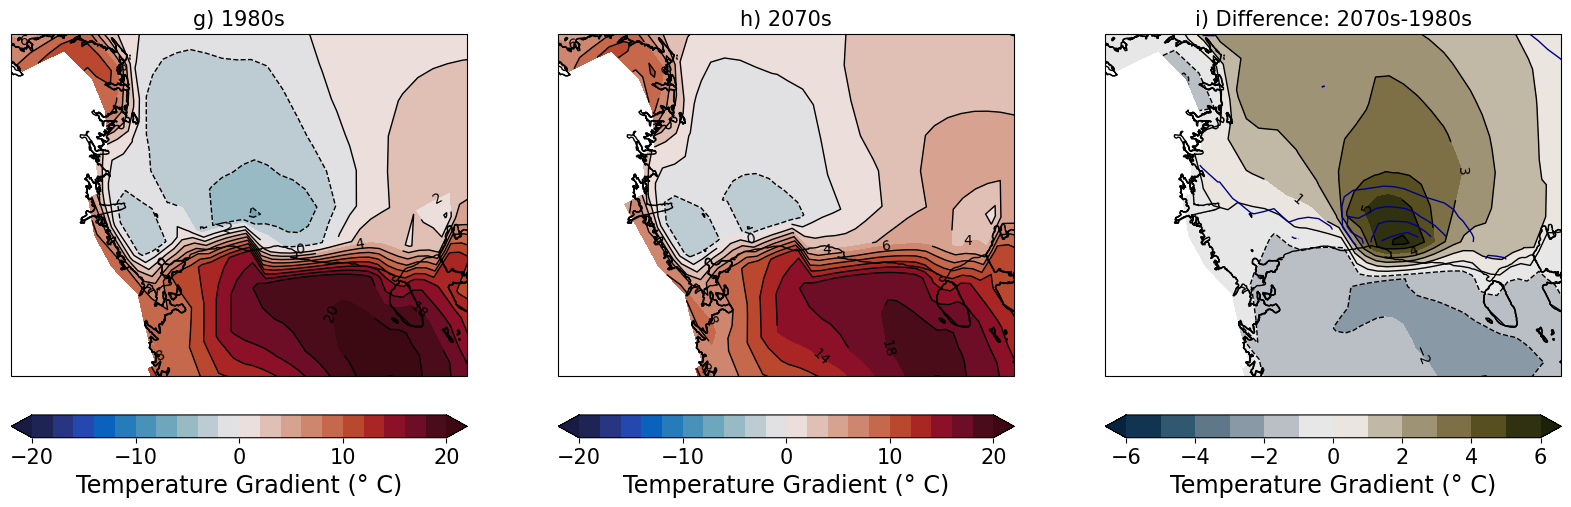

In [99]:
## 2070's difference figure
tag = '2070'
lev = 85000

# select data
data_ctrl = decade_means_3.sel(decade='1980',plev=lev)
data_in = decade_means_3.sel(decade=tag,plev=lev)
data_diff = data_in - data_ctrl

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# select ice data
data_ice_ctrl = 100*decade_means_ice.sel(decade='1980')
data_ice_in = 100*decade_means_ice.sel(decade=tag)
data_ice_diff = data_ice_in - data_ice_ctrl

# create figure
fig = plt.figure(figsize=(20,10))

# get lats/lons for plotting
lons = ds_1.lon
lats = ds_1.lat
lons_ice = ds_ice.TLON
lats_ice = ds_ice.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)

### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('g) 1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('h) '+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_diff,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_diff)
# add significance overtop - stippling where it is NOT significant
#this3 = ax.pcolor(lons,lats,
#                  sig2,
#                  transform=ccrs.PlateCarree(),
#                  hatch='.',
#                  alpha= 0)
# add ice difference contours overtop
color = 'darkblue'
this1 = ax.contour(lons_ice,lats_ice,
                   data_ice_diff,
                   transform=ccrs.PlateCarree(),
                   colors = color,
                   levels=levels_ice_diff,extend='both',linewidths=1)
#plt.clabel(this1,colors=color,inline=1,fontsize=10,levels=ticks_ice_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title('i) Difference: '+tag+'s-1980s',fontsize=15)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)